In [ ]:
import random
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from casadi import dot, vertcat, vertsplit
from do_mpc.controller import MPC
from do_mpc.model import Model
from do_mpc.simulator import Simulator
from tqdm import tqdm

from core.generator import (
    gen_step,
)
from core.greenhouse_model import A_p as greenhouse_area
from core.greenhouse_model import _model as _gh_model
from core.greenhouse_model import heater, ventilation
from core.greenhouse_model import model as gh_model
from core.openmeteo_query import get_weather_data
from core.plot import plot_response, plot_states
from core.simulate import simulate
from examples.GES_Example import z

# For reproducibility
random.seed(40)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Get Weather Data

In [ ]:
sim_days = 16

climdat = get_weather_data(
    latitude=52.52,  # Latitude of the location in degrees
    longitude=13.41,  # Longitude of the location in degrees
    tilt=[
        90,
        40,
        90,
        40,
        90,
        40,
        90,
        40,
    ],  # Tilt angle of the surface in degrees
    azimuth=[
        "NE",
        "NE",
        "SE",
        "SE",
        "SW",
        "SW",
        "NW",
        "NW",
    ],  # Azimuth angle of the surface in degrees (South facing)
    frequency="hourly",
    forecast=sim_days,
)

climate = climdat.asfreq("1T").interpolate(method="time").values

## Explore responses to steps in individual inputs

In [ ]:
ts = 60

x0 = z

u_min = [0.0, 0.0]
u_max = [100.0, 100.0]

In [ ]:
y_label = [r"$x_{\mathrm{sdw}}$", r"$x_{\mathrm{nsdw}}$"]
u_label = [
    r"$u_{\mathrm{R_{a,max}}}$",
    r"$u_{\mathrm{Q_{heat}}}$",
]

In [ ]:
greenhouse_model = partial(gh_model, climate=climate)

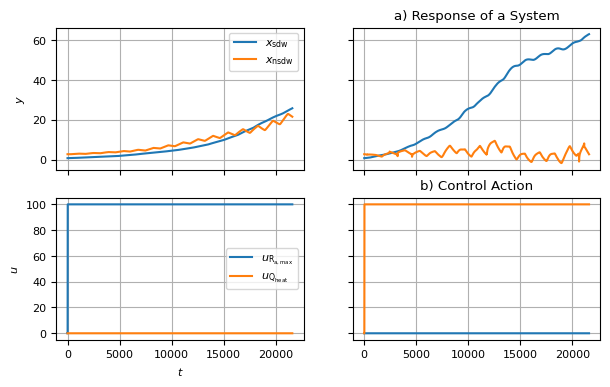

In [ ]:
# [donotremove]
fig, axs = plt.subplots(nrows=2, ncols=len(u_max), sharex=True, sharey="row")

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model, u=u, sim_time=1440 * sim_days, t_s=ts, x0=x0
    )
    plot_response(
        t_out,
        y_out[:, -2:],
        u_out,
        axs_=axs[:, u_idx],
        y_label=y_label,
        u_label=u_label,
    )

axs[0, 0].set_ylabel("$y$")
axs[0, 1].set_title("a) Response of a System")
axs[0, 0].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 1].set_title("b) Control Action")
axs[1, 0].legend()

plt.show()

### Plot all the hidden states

In [ ]:
_greenhouse_model = partial(_gh_model, climate=climate)

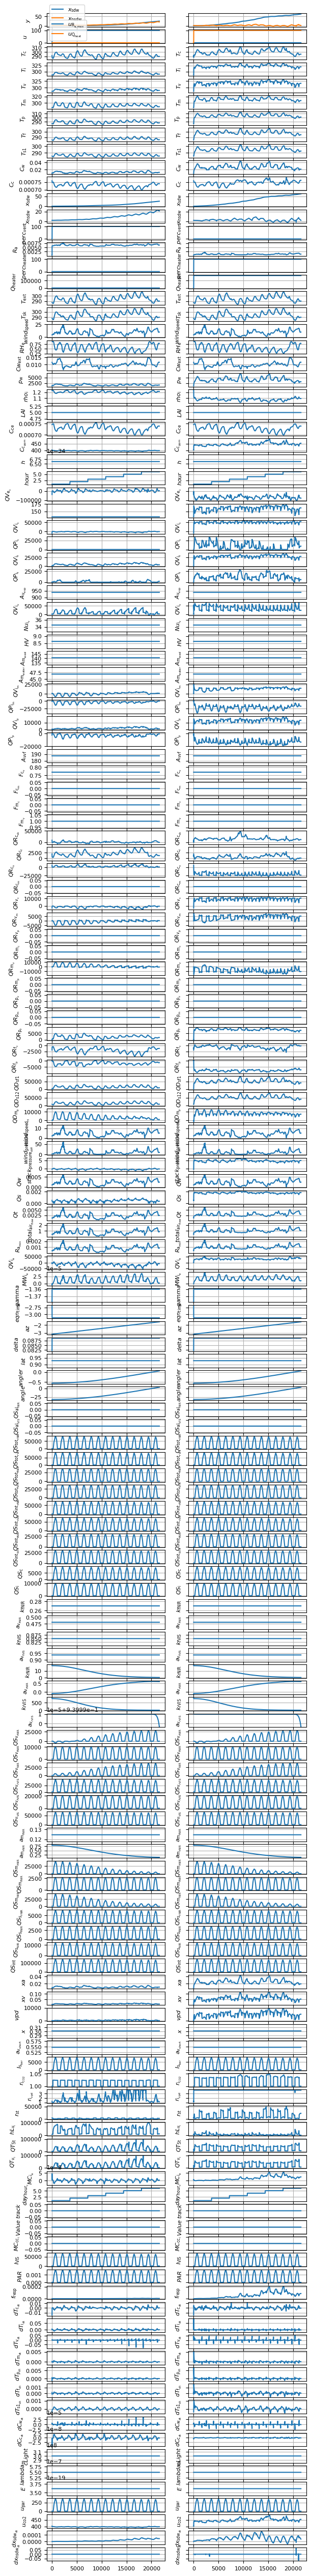

In [ ]:
# [donotremove]
for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model, u=u, sim_time=1440 * sim_days, t_s=ts, x0=x0
    )

    xs = []
    for i, (x, u) in enumerate(zip(y_out, u_out)):
        _, x_ = _greenhouse_model(i, tuple(x), tuple(u))
        xs.append(x_)
    df = pd.DataFrame(xs).select_dtypes(include=["float"])

    if u_idx == 0:
        # Plot response
        fig, axs = plt.subplots(
            nrows=2 + len(df.columns),
            ncols=len(u_max),
            figsize=(6, round(len(df.columns) / 2)),
            sharex=True,
            sharey="row",
        )
    plot_response(
        t_out,
        y_out[:, -2:],
        u_out,
        axs_=axs[:, u_idx],
        y_label=y_label,
        u_label=u_label,
    )
    # Plot states
    plot_states(df, axs[2:, u_idx])

axs[0, 0].set_ylabel("$y$")
axs[0, 0].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 0].legend()

plt.show()

In [ ]:
# === Model ===================================================================
# Create a model instance
model = Model("discrete")

dt = 60  # [s]
# Define optimization variables
n_states = len(z)
n_controls = 2
# Define state and control variables
t = model.set_variable(var_type="_tvp", var_name="t", shape=(1, 1))
x = model.set_variable(var_type="_x", var_name="x", shape=(n_states, 1))
u = model.set_variable(var_type="_u", var_name="u", shape=(n_controls, 1))
tvp = {
    name: model.set_variable(var_type="_tvp", var_name=name)
    for name in climdat.columns
}


# Define the model equations
def f(t, x, u, tvp):
    return vertcat(
        *gh_model(t, vertsplit(x), vertsplit(u), climate=tuple(tvp.values()))
    )


k1 = f(t, x[:, 0], u[:, 0], tvp)
k2 = f(t, x[:, 0] + dt / 2 * k1, u[:, 0], tvp)
k3 = f(t, x[:, 0] + dt / 2 * k2, u[:, 0], tvp)
k4 = f(t, x[:, 0] + dt * k3, u[:, 0], tvp)
x_next = x[:, 0] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

model.set_rhs("x", x_next)

model.setup()

# === MPC =====================================================================
# Parameters
lettuce_price = 0.0054  # EUR/g
N = 60  # number of control intervals
x_ref = np.array([50.0, 5.0])  # reference state
u_min = [0.0, 0.0]
u_max = [100.0, 100.0]

# Create an MPC instance
mpc = MPC(model)

# Set parameters
setup_mpc = {
    "n_horizon": N,
    "t_step": dt,
    "supress_ipopt_output": True,
}
mpc.set_param(**setup_mpc)

# Define objective
mpc.set_objective(
    mterm=dot(x[-2] - x_ref[0], x[-2] - x_ref[0]) * 0,  # ca.DM(0)
    lterm=(
        -dot(
            lettuce_price * x[-2] * greenhouse_area,
            lettuce_price * x[-2] * greenhouse_area,
        )
        + dot(ventilation.signal_to_eur(u[0]), ventilation.signal_to_eur(u[0]))
        + dot(heater.signal_to_eur(u[1]), heater.signal_to_eur(u[1]))
        + dot(
            lettuce_price * z[-2] * greenhouse_area,
            lettuce_price * x[-2] * greenhouse_area,
        )
    ),
)

# mpc.set_rterm(
#     u=np.array([1] * n_controls)
# )  # Parametrize with size of greenhouse and Ts


# Define path constraints
mpc.bounds["lower", "_u", "u"] = u_min
mpc.bounds["upper", "_u", "u"] = u_max

mpc.bounds["lower", "_x", "x"] = [0.0] * n_states

# Get the template
tvp_mpc_template = mpc.get_tvp_template()


# Define the function (indexing is much simpler ...)
def tvp_mpc_fun(t_now):
    # N is the horizon with given ts
    for k in range(N + 1):
        tvp_mpc_template["_tvp", k, "t"] = (t_now / dt) + k
        for i, key in enumerate(climdat.columns):
            tvp_mpc_template["_tvp", k, key] = climate[int(t_now / dt) + k][i]
    return tvp_mpc_template


# Set the tvp_fun:
mpc.set_tvp_fun(tvp_mpc_fun)
# https://licences.stfc.ac.uk/product/coin-hsl
mpc.settings.set_linear_solver(solver_name="MA97")
# https://coin-or.github.io/Ipopt/OPTIONS.html
mpc.settings.nlpsol_opts = {
    "ipopt": {
        "max_iter": 3,
        "print_level": 0,
        # "output_file": "ipopt.out",
        "print_user_options": "yes",
        "print_options_documentation": "yes",
        "print_frequency_iter": 4,
    }
}
mpc.settings.supress_ipopt_output
mpc.setup()

# === Simulator ===============================================================
# Create a simulator
simulator = Simulator(model)

params_simulator = {"t_step": dt}

simulator.set_param(**params_simulator)

# Get the template
tvp_sim_template = simulator.get_tvp_template()


# Define the function (indexing is much simpler ...)
def tvp_sim_fun(t_now):
    tvp_sim_template["t"] = t_now / dt
    for i, key in enumerate(climdat.columns):
        tvp_sim_template[key] = climate[int(t_now / dt)][i]
    return tvp_sim_template


# Set the tvp_fun:
simulator.set_tvp_fun(tvp_sim_fun)

simulator.setup()

# === Runtime =================================================================
sim_steps = 24 * sim_days
# Find feasible initial state
x0 = z
u0 = np.array([0.0, 0.0])
for k in range(N):
    k1 = greenhouse_model(k, x0, u0)
    k2 = greenhouse_model(k, x0 + dt / 2 * k1, u0)
    k3 = greenhouse_model(k, x0 + dt / 2 * k2, u0)
    k4 = greenhouse_model(k, x0 + dt * k3, u0)
    x_next = x0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    x0 = x_next

x0_ = np.array(x0)
mpc.x0 = x0_
simulator.x0 = x0_
mpc.set_initial_guess()

# Run the MPC simulation
u0s = []
y_nexts = []
x0s = []
ums = []
uos = []
for _ in tqdm(range(sim_steps)):
    ums.append([u_min, u_max])
    mpc.bounds["upper", "_u", "u"] = u_max
    mpc.bounds["lower", "_u", "u"] = u_min
    u0 = mpc.make_step(x0_)
    u0s.append(u0)
    y_next = simulator.make_step(u0)
    y_nexts.append(y_next[-2:])
    x0_ = y_next
    x0s.append(x0_)

In [ ]:
print(
    f"Congrats, your greenhouse generated profit of {np.sqrt(-np.mean(np.array(mpc.solver_stats["iterations"]["obj"]))):.2f} EUR! 🤑"
)

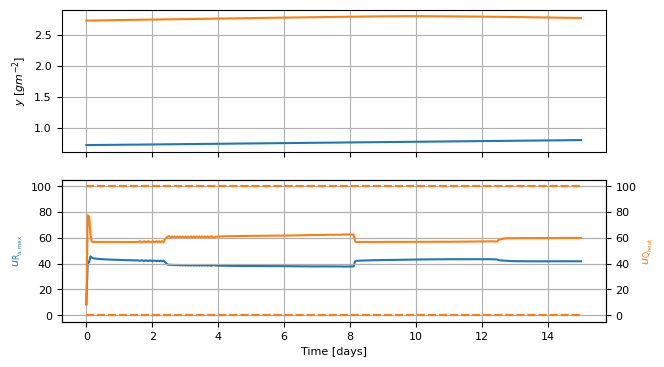

In [ ]:
# [donotremove]
fig, axs = plt.subplots(2, 1, sharex=True)
t_out = np.linspace(0, sim_days, len(y_nexts))
axs[0].plot(t_out, np.array(y_nexts).reshape(-1, 2))
axs[0].set_ylabel("$y~[g m^{-2}]$")
for i, (label, color) in enumerate(
    zip(
        [
            r"$u_{\mathrm{R_{a,max}}}$",
            r"$u_{\mathrm{Q_{heat}}}$",
        ],
        ["#1f77b4", "#ff7f0e"],
    )
):
    # Create a second y-axis
    if i > 0:
        ax = axs[1].twinx()
    else:
        ax = axs[1]
    if i > 1:
        ax.spines["right"].set_position(("outward", 20 * i))
    ax.plot(t_out, np.array(u0s).reshape(-1, 2)[:, i], color=color)
    ax.plot(
        t_out, np.array(ums).reshape(-1, 4)[:, i], linestyle="--", color=color
    )
    ax.plot(
        t_out,
        np.array(ums).reshape(-1, 4)[:, i + 2],
        linestyle="--",
        color=color,
    )

    ax.set_ylabel(label, color=color)
    ax.set_xlabel("Time [days]")